# Cognitive Decline Prediction Using EEG Data and Machine Learning

## Imports

In [1]:
import mne
from bids import BIDSLayout
import os
import numpy as np
import pandas as pd

### Data Preprocessing

The EEG recordings were exported in .eeg format and transformed to the BIDS-accepted .set format, with a preprocessing pipeline that included applying a Butterworth band-pass filter (0.5-45 Hz), re-referencing, and using Artifact Subspace Reconstruction (ASR) to remove bad data segments. Independent Component Analysis (ICA) was then performed to identify and reject components classified as eye or jaw artifacts, even though some eye movement artifacts remained in the resting state recordings.

In [2]:
data_path = "data/derivatives"

## Load Data

Let's create a dataframe that includes both are participants.tsv data and EEG data.

In [3]:
# Function to load subject data
def load_subject_data(subject_id):
    subject_path = os.path.join(data_path, f"sub-{subject_id:03d}", "eeg", f"sub-{subject_id:03d}_task-eyesclosed_eeg.set")
    # print(f"Trying to load: {subject_path}")  # Debugging line
    raw = mne.io.read_raw_eeglab(subject_path, preload=True)  # Load the .set file
    return raw

In [5]:
'''def load_all_subjects(data_path, num_subjects=88):
    raw_data_list = []
    for subject_id in range(1, num_subjects + 1):
        try:
            raw = load_subject_data(subject_id)  # Load your EEG data here
            raw_data_list.append(raw)
            print(f"Loaded data for subject {subject_id}")
        except FileNotFoundError:
            print(f"Data for subject {subject_id} not found.")
    return raw_data_list'''

In [49]:
'''raw_data = load_subject_data(1)
if raw_data is not None:
    print(raw_data.info)  # Access the info attribute directly
else:
    print("No data was loaded.")
    
raw_data.plot(n_channels=10, scalings='auto') # Test if data was loaded correctly'''

'raw_data = load_subject_data(1)\nif raw_data is not None:\n    print(raw_data.info)  # Access the info attribute directly\nelse:\n    print("No data was loaded.")\n    \nraw_data.plot(n_channels=10, scalings=\'auto\') # Test if data was loaded correctly'

In [4]:
# Load participant data
participant_data_path = 'data/participants.tsv'
participant_data = pd.read_csv(participant_data_path, sep='\t')

# Create a list to hold EEG data
eeg_data_list = []

# Load EEG data for each subject and store it in a list
for subject_id in range(1, 89):  # Assuming 88 subjects
    try:
        raw = load_subject_data(subject_id)
        eeg_data_list.append(raw)
    except FileNotFoundError:
        print(f"Data for subject {subject_id} not found.")

# Create a DataFrame for EEG data
eeg_df = pd.DataFrame({
    'participant_id': [f'sub-{str(i).zfill(3)}' for i in range(1, 89)],
    'eeg_data': eeg_data_list
})

# Check if all EEG data has been loaded
print(f"Loaded EEG data for {len(eeg_data_list)} subjects.")

# Merge EEG data with participant information
combined_data = pd.merge(eeg_df, participant_data, on='participant_id')

# Display summary of combined data instead of the entire DataFrame
# For example, display the first few rows of participant information and EEG data shapes
print(combined_data[['participant_id'] + list(participant_data.columns)])  # Adjust according to actual participant data columns

# If you want to see the shape of the EEG data
for index, row in combined_data.iterrows():
    print(f"{row['participant_id']} EEG data shape: {row['eeg_data'].get_data().shape}")

/var/folders/08/7smt69cx1jgg6n2hw3w69f_c0000gn/T/ipykernel_29616/1003593807.py:5: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(subject_path, preload=True)  # Load the .set file
/var/folders/08/7smt69cx1jgg6n2hw3w69f_c0000gn/T/ipykernel_29616/1003593807.py:5: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(subject_path, preload=True)  # Load the .set file
/var/folders/08/7smt69cx1jgg6n2hw3w69f_c0000gn/T/ipykernel_29616/1003593807.py:5: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(subject_path, preload=True)  # Load the .set file
/var/folders/08/7smt69cx1jgg6n2hw3w69f_c0000gn/T/ipykernel_29616/1003593807.

Loaded EEG data for 88 subjects.
   participant_id participant_id Gender  Age Group  MMSE
0         sub-001        sub-001      F   57     A    16
1         sub-002        sub-002      F   78     A    22
2         sub-003        sub-003      M   70     A    14
3         sub-004        sub-004      F   67     A    20
4         sub-005        sub-005      M   70     A    22
..            ...            ...    ...  ...   ...   ...
83        sub-084        sub-084      F   71     F    24
84        sub-085        sub-085      M   64     F    26
85        sub-086        sub-086      M   49     F    26
86        sub-087        sub-087      M   73     F    24
87        sub-088        sub-088      M   55     F    24

[88 rows x 6 columns]
sub-001 EEG data shape: (19, 299900)
sub-002 EEG data shape: (19, 396550)
sub-003 EEG data shape: (19, 153050)
sub-004 EEG data shape: (19, 353050)
sub-005 EEG data shape: (19, 402050)
sub-006 EEG data shape: (19, 316200)
sub-007 EEG data shape: (19, 383210)
s

### Encoding Labels

Encode the group labels into numerical format:
Alzheimer's Disease (A) = 0
Frontotemporal Dementia (F) = 1
Healthy Control (C) = 2

In [5]:
group_mapping = {'A': 0, 'F': 1, 'C': 2}
combined_data['Group'] = combined_data['Group'].map(group_mapping)

In [6]:
# Save the combined data to a CSV file
output_csv_path = 'data/combined_eeg_participant_data.csv'
combined_data.to_csv(output_csv_path, index=False)

print(f"Combined data saved to {output_csv_path}")

Combined data saved to data/combined_eeg_participant_data.csv


## Define Feature Extraction Functions

Let's define functions to extract relevant features from your EEG data.

### Bandpower Extraction 

Analyze how different frequency bands (delta, theta, alpha, beta, gamma) change across different brain regions (channels).

In [34]:
def extract_bandpower(raw, freq_bands, n_fft=2048):
    """Extract bandpower features from EEG data."""
    # Compute the Power Spectral Density (PSD)
    spectrum = raw.compute_psd(method='welch', n_fft=n_fft)
    psd_data, freqs = spectrum.get_data(return_freqs=True)

    bandpowers = {}
    for band, (fmin, fmax) in freq_bands.items():
        # Find the indices of frequencies within the specified band
        band_idx = np.where((freqs >= fmin) & (freqs <= fmax))[0]
        # Average the PSD values over the band
        bandpower = np.mean(psd_data[:, band_idx], axis=1)  # Average across all frequencies in the band
        bandpowers[band] = bandpower

    return bandpowers


### Set Indices of Frequencies and Initialize Feature Dictionary

In [36]:
freq_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (12, 25),
    'gamma': (25, 45)
}

# Create a list to hold the feature dictionaries
features_list = []

### Power Spectral Density (PSD)

Using the Welch method is a technique for estimating the power of a signal's frequency components. It provides a way to analyze the distribution of power across different frequencies in a signal, making it useful for identifying dominant frequency components in various applications such as EEG analysis

In [38]:
# Function to compute band power for different frequency bands per channel
def compute_bandpower_per_channel(raw, freq_range):
    # Compute the power spectral density using Welch's method
    spectrum = raw.compute_psd(method="welch")
    # Retrieve the power spectral density data and corresponding frequencies
    data, freqs = spectrum.get_data(return_freqs=True)

    # Find indices of the frequency range
    freq_indices = np.logical_and(freqs >= freq_range[0], freqs <= freq_range[1])
    # Compute the average power in the desired frequency band for each channel
    band_power = np.mean(data[:, freq_indices], axis=1)  # Average power for each channel
    
    return band_power

### Connectivity Measures

Connectivity measures are useful for assessing interactions between different EEG channels or brain regions. Correlation measures linear dependency between signals from different channels.

In [39]:
# Function to compute connectivity between EEG channels
def compute_connectivity(raw):
    """
    Computes the functional connectivity using correlation between channels.
    
    Parameters:
        raw: MNE Raw object containing the EEG data.
        
    Returns:
        Connectivity matrix (correlation coefficients).
    """
    data = raw.get_data()  # Get all channels, shape (n_channels, n_samples)
    connectivity_matrix = np.corrcoef(data)  # Calculate correlation coefficients
    return connectivity_matrix

###  Extract Features and Append to Feature Dictionary

In [40]:
# Iterate over the rows in combined_data
for index, row in combined_data.iterrows():
    raw = row['eeg_data']  # Get the raw EEG data
    bandpower_results = {}

    # Calculate band power for each frequency band for each channel
    for band, freq_range in freq_bands.items():
        bandpower_results[band] = compute_bandpower_per_channel(raw, freq_range)

    # Create a feature dictionary
    features = {
        'participant_id': row['participant_id'],
        'Gender': row['Gender'],
        'Age': row['Age'],
        'Group': row['Group'],
        'MMSE': row['MMSE']
    }

    # Add bandpower features for each channel
    for band, power in bandpower_results.items():
        # Assuming you have 'n_channels' number of channels
        for i, channel_power in enumerate(power):
            features[f'bandpower_{band}_channel_{i+1}'] = channel_power  # +1 for human-readable indexing

    # Calculate and add connectivity features
    connectivity_matrix = compute_connectivity(raw)
    
    # For simplicity, you can extract average connectivity or specific values
    features['average_connectivity'] = np.mean(connectivity_matrix)  # Average connectivity across channels

    # Example: Add specific channel correlations if desired
    # features['connectivity_1_2'] = connectivity_matrix[0, 1]  # Correlation between channel 1 and channel 2

    features_list.append(features)


Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective wind

In [41]:
# Create a new DataFrame for features
features_df = pd.DataFrame(features_list)

# Display the features DataFrame
print(features_df.head())

  participant_id Gender  Age  Group  MMSE  bandpower_delta_channel_1  \
0        sub-001      F   57      0    16               1.543225e-10   
1        sub-002      F   78      0    22               1.346914e-10   
2        sub-003      M   70      0    14               1.218853e-10   
3        sub-004      F   67      0    20               1.551064e-10   
4        sub-005      M   70      0    22               1.626046e-10   

   bandpower_delta_channel_2  bandpower_delta_channel_3  \
0               1.530897e-10               1.465526e-10   
1               1.327193e-10               1.348418e-10   
2               1.206538e-10               1.169528e-10   
3               1.565050e-10               1.534913e-10   
4               1.390470e-10               1.478077e-10   

   bandpower_delta_channel_4  bandpower_delta_channel_5  ...  \
0               1.467994e-10               1.448965e-10  ...   
1               1.330593e-10               1.345511e-10  ...   
2               1.19

In [42]:
# Save features to a CSV file
features_df.to_csv('data/extracted_features.csv', index=False)
print("Extracted features saved to extracted_features.csv")

Extracted features saved to extracted_features.csv


In [43]:
# Display descriptive statistics
print(features_df.describe())

             Age      Group       MMSE  bandpower_delta_channel_1  \
count  88.000000  88.000000  88.000000               8.800000e+01   
mean   66.170455   0.920455  22.943182               1.673873e-10   
std     7.362879   0.860655   6.150148               4.705946e-11   
min    44.000000   0.000000   4.000000               1.039797e-10   
25%    61.750000   0.000000  20.000000               1.516909e-10   
50%    67.000000   1.000000  22.000000               1.603028e-10   
75%    71.000000   2.000000  30.000000               1.710038e-10   
max    79.000000   2.000000  30.000000               5.011044e-10   

       bandpower_delta_channel_2  bandpower_delta_channel_3  \
count               8.800000e+01               8.800000e+01   
mean                1.670218e-10               1.612226e-10   
std                 4.057619e-11               3.392604e-11   
min                 1.015304e-10               1.057678e-10   
25%                 1.522450e-10               1.502753e-10   


## Data Visualization 

Visually compare the distribution of various bandpower features among different groups of participants using a boxplot and correlation matrix. We will use these plots to determine which channel recordings and frequency types correlate with our patient groupings.

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame for easier plotting
melted_features = features_df.melt(id_vars=['participant_id', 'Gender', 'Age', 'Group', 'MMSE', 'average_connectivity'], 
                                    var_name='Feature', value_name='Value')

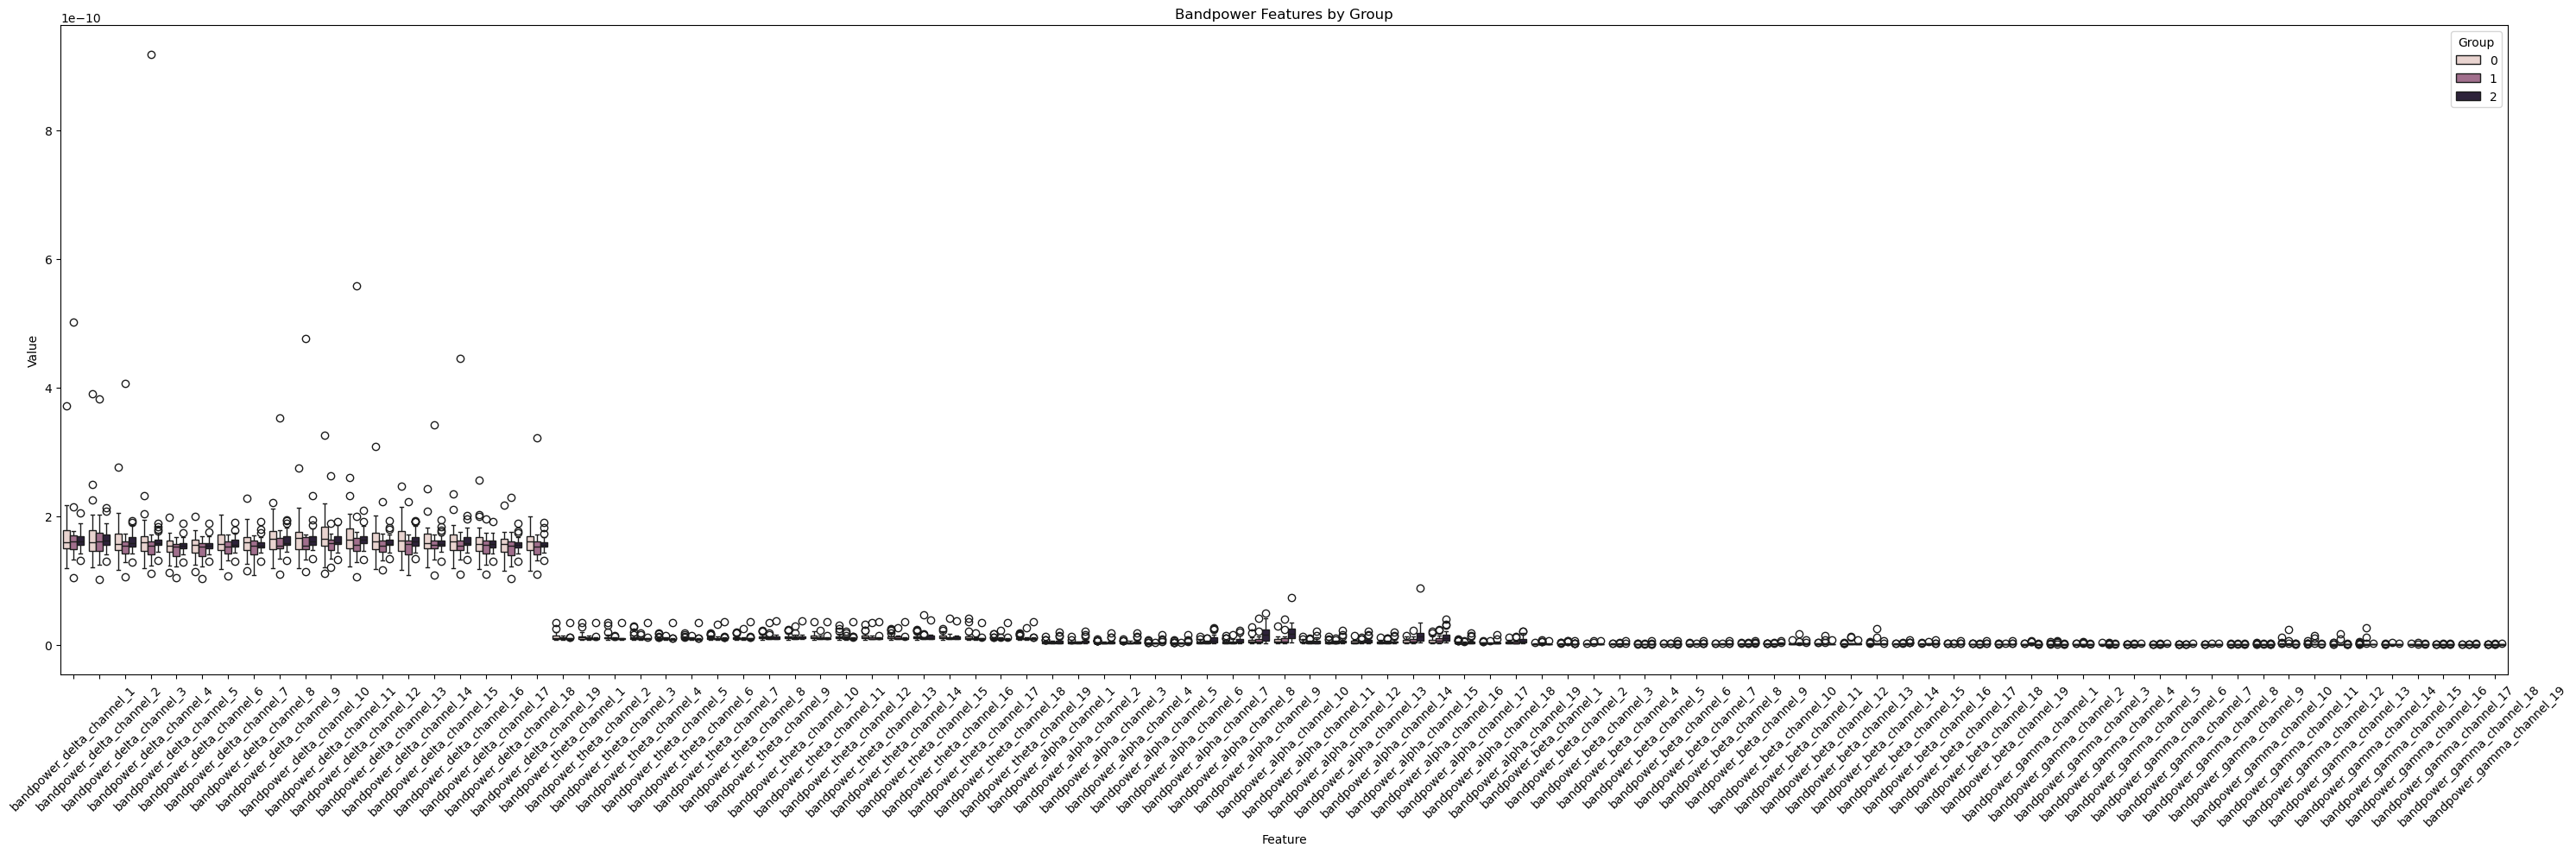

In [45]:
# Create a boxplot for bandpower features
plt.figure(figsize=(30, 10))
sns.boxplot(x='Feature', y='Value', hue='Group', data=melted_features)
plt.title('Bandpower Features by Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
numeric_features_df = features_df.select_dtypes(include=[np.number])

In [47]:
correlation_matrix = numeric_features_df.corr()

In [51]:
# Step 2: Extract correlations with "Group" and drop self-correlation
group_correlation = correlation_matrix['Group'].drop('Group')  # Drop self-correlation

# Step 3: Get absolute values of the correlations
absolute_group_correlation = group_correlation.abs()

# Step 4: Sort the absolute correlations in descending order
sorted_group_correlation = absolute_group_correlation.sort_values(ascending=False)

# Display the sorted correlations
print(sorted_group_correlation[:20])

MMSE                          0.850377
bandpower_alpha_channel_10    0.467631
bandpower_alpha_channel_9     0.450489
bandpower_alpha_channel_15    0.401546
bandpower_alpha_channel_16    0.389406
bandpower_alpha_channel_7     0.381889
bandpower_alpha_channel_19    0.365472
bandpower_beta_channel_15     0.336868
bandpower_beta_channel_10     0.333757
bandpower_beta_channel_9      0.299542
bandpower_alpha_channel_8     0.290250
bandpower_beta_channel_16     0.247384
bandpower_alpha_channel_13    0.241350
bandpower_beta_channel_7      0.237633
bandpower_alpha_channel_4     0.230623
bandpower_theta_channel_11    0.226883
bandpower_alpha_channel_17    0.220700
bandpower_alpha_channel_2     0.216305
bandpower_alpha_channel_1     0.215286
bandpower_beta_channel_19     0.202237
Name: Group, dtype: float64


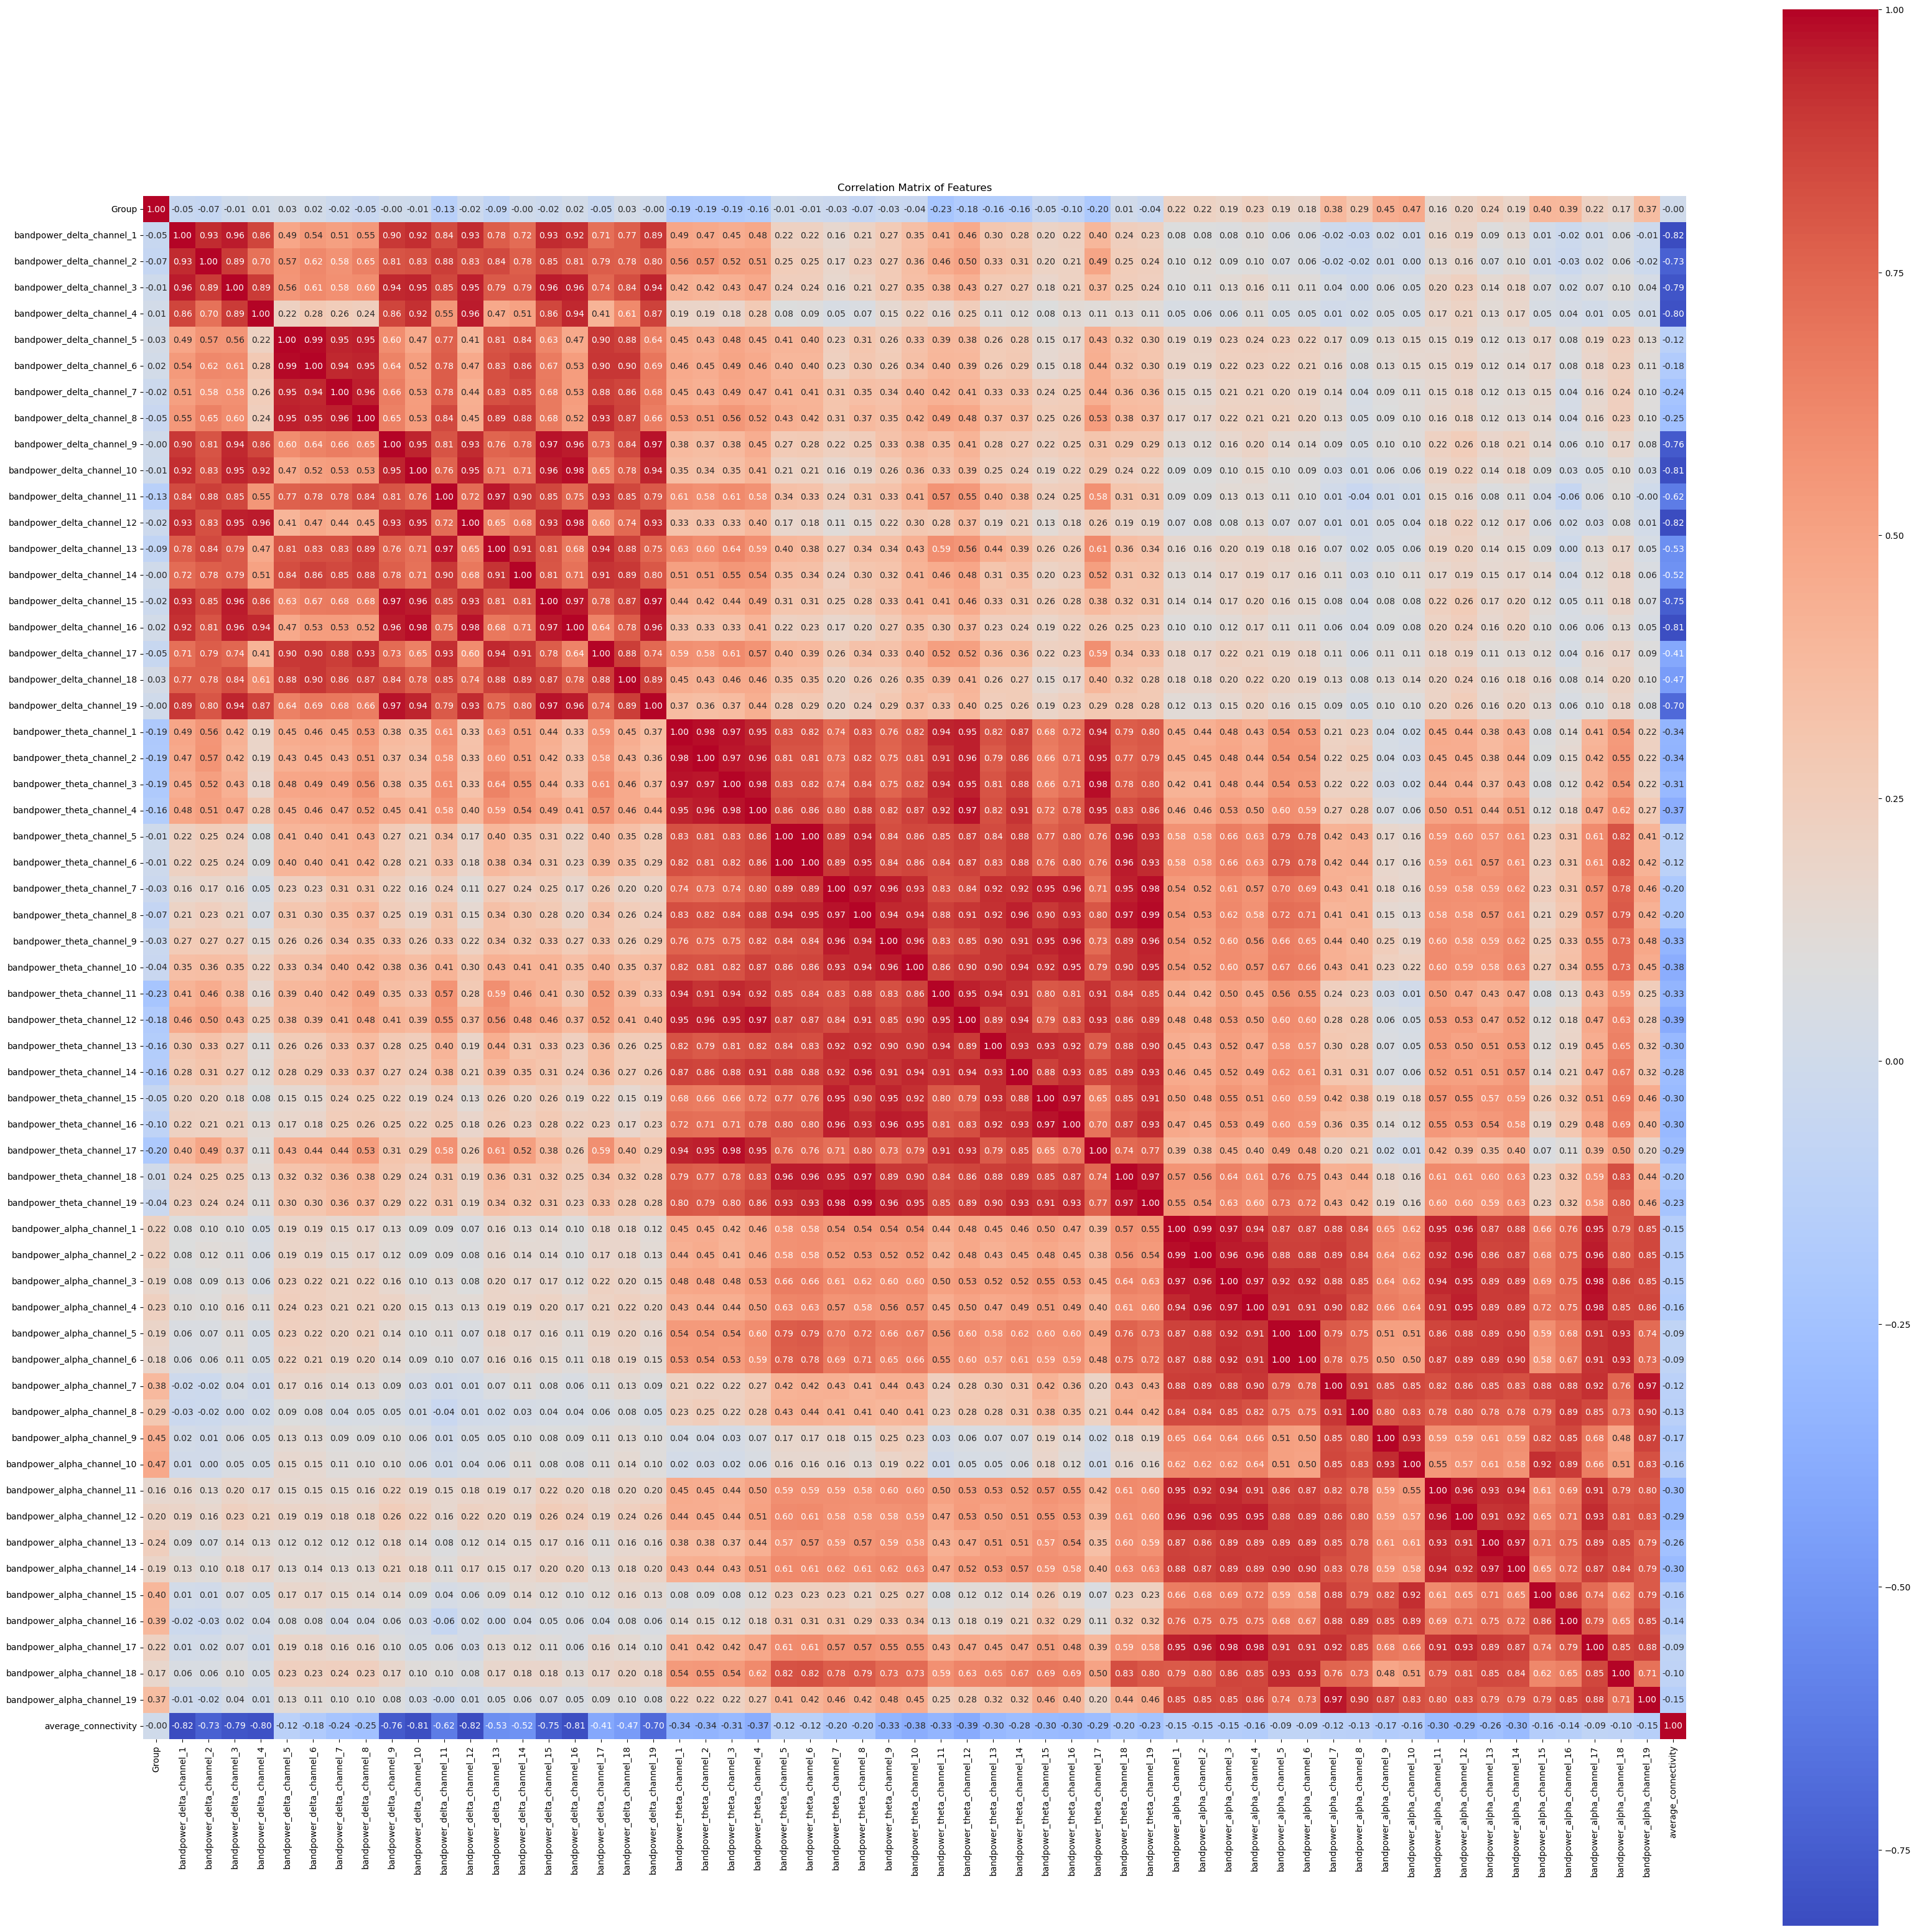

In [52]:

'''plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features')
plt.show()'''

# Define the columns to drop (for both bandpower_gamma and bandpower_beta, plus Age and MMSE)
columns_to_drop = [col for col in correlation_matrix.columns if 'bandpower_gamma' in col or 'bandpower_beta' in col] + ['Age', 'MMSE']

# Drop the specified columns and rows from the correlation matrix
filtered_corr_matrix = correlation_matrix.drop(columns=columns_to_drop)

# Drop the same rows to keep the matrix symmetric
filtered_corr_matrix = filtered_corr_matrix.drop(index=columns_to_drop)

# Plot the filtered correlation matrix
plt.figure(figsize=(40, 40))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features')
plt.show()


### We care about 'Group' correlation in our matrix

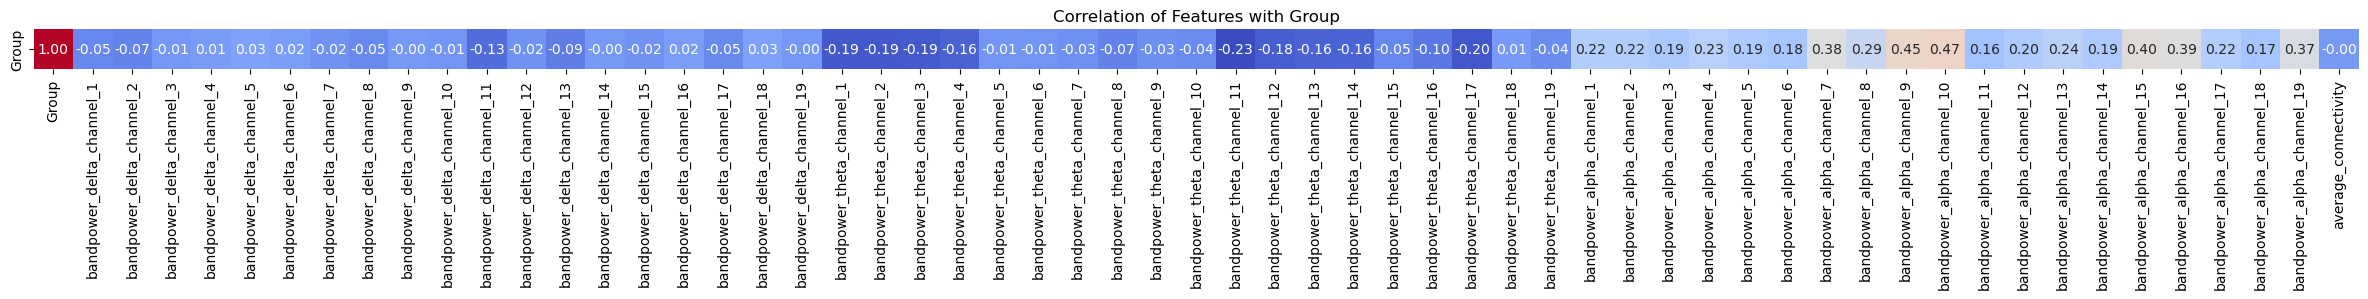

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_matrix is already defined
# Define the columns to drop (for both bandpower_gamma and bandpower_beta, plus Age and MMSE)
columns_to_drop = [col for col in correlation_matrix.columns if 'bandpower_gamma' in col or 'bandpower_beta' in col] + ['Age', 'MMSE']

# Drop the specified columns to create a filtered correlation matrix
filtered_corr_matrix = correlation_matrix.drop(columns=columns_to_drop)

# Select only the "Group" row from the filtered correlation matrix
group_corr_matrix = filtered_corr_matrix.loc[['Group']]

# Plot the correlation matrix for "Group" only
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
sns.heatmap(group_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=False)
plt.title('Correlation of Features with Group')
plt.show()


## Relevant Feature Extraction

This way, we will only train our model using the top features that provide the highest accuracy.

According to the literature, AD patients exhibit changes in the RBP such as reduced alpha power and increased theta power.

In [53]:
# Step 1: Extract the top 19 feature names, excluding MMSE
top_features = sorted_group_correlation.index[:19].tolist()

# Step 2: Remove MMSE if it's in the top features
top_features = [feature for feature in top_features if feature != 'MMSE'] # We wonly want to use EEG

# Step 3: Format the list to match your desired output
feature_columns = [f"{feature}" for feature in top_features]

# Print the feature columns in the desired format
formatted_feature_columns = ',\n    '.join(feature_columns)
formatted_output = f"feature_columns = [\n    {formatted_feature_columns}\n]"

print(formatted_output)


feature_columns = [
    bandpower_alpha_channel_10,
    bandpower_alpha_channel_9,
    bandpower_alpha_channel_15,
    bandpower_alpha_channel_16,
    bandpower_alpha_channel_7,
    bandpower_alpha_channel_19,
    bandpower_beta_channel_15,
    bandpower_beta_channel_10,
    bandpower_beta_channel_9,
    bandpower_alpha_channel_8,
    bandpower_beta_channel_16,
    bandpower_alpha_channel_13,
    bandpower_beta_channel_7,
    bandpower_alpha_channel_4,
    bandpower_theta_channel_11,
    bandpower_alpha_channel_17,
    bandpower_alpha_channel_2,
    bandpower_alpha_channel_1
]


## Split  dataset into training and testing subsets

In [54]:
from sklearn.model_selection import train_test_split

# Select features and target variable
X = features_df[feature_columns]  # Features with selected columns
y = features_df['Group']           # Target variable (you can change this based on your analysis)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Print the shapes of the training and testing sets to confirm
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (70, 18), X_test shape: (18, 18)
y_train shape: (70,), y_test shape: (18,)


### SMOTE (Synthetic Minority Over-sampling Technique)

Used to generate synthetic samples for the minority class in a dataset. This helps to balance the class distribution, reducing bias in the model's predictions.

In [55]:
# Check value counts before SMOTE
print("Before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE to resample the training data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check value counts after SMOTE
print("\nAfter SMOTE:")
print(y_train_resampled.value_counts())


Before SMOTE:
Group
0    28
2    27
1    15
Name: count, dtype: int64

After SMOTE:
Group
2    28
1    28
0    28
Name: count, dtype: int64


## XGBoost Model Training and Evaluation

This section demonstrates how to train an XGBoost classifier using the resampled training dataset. The model is fitted on the training data, predictions are made on the test set, and the accuracy of the model is evaluated using the accuracy score metric.

In [56]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Train an XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the XGBoost model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost model accuracy: {accuracy:.2f}")


XGBoost model accuracy: 0.61


In [57]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.75      0.38      0.50         8
           2       0.40      1.00      0.57         2

    accuracy                           0.61        18
   macro avg       0.61      0.71      0.59        18
weighted avg       0.67      0.61      0.60        18

